# Extracting Features W2V

### Setup

In [1]:
%run -i 'random_state.py'
from packages import *
from clean_functions import *
from tokenizer import *

### Loading W2V model

In [2]:
word = KeyedVectors.load("models/doc2vec_mov_100_10")
embed_dim=np.shape(word['juiz'])[0]
embed_dim

100

Vocab:

In [3]:
word_vectors = word.wv

### Preparing datasets

In [4]:
with open("data/mov.txt", "rb") as fp:   # Legal proceedings
    mov = pickle.load(fp)

with open("data/tags.txt", "rb") as fp:   # Tags
    tags = pickle.load(fp)

Letting motions in cronological order:

In [5]:
mov[0][:4]

[['14-11-2018',
  'Tipo do Movimento:Ato Ordinatório Praticado Descrição:Certifico e dou fé que as custas pendentes de fls 685 não foram recolhidas pelas parte GILMAR RODRIGUES REGO e BRUNO MEDEIROS.'],
 ['23-07-2018',
  'Tipo do Movimento:Juntada - Petição Descrição da juntada:Documento eletrônico juntado de forma automática.'],
 ['16-07-2018',
  'Tipo do Movimento:Publicado\xa0 Atos da Serventia Folhas do DJERJ.:388/416'],
 ['29-06-2018', 'Tipo do Movimento:Enviado para publicação ']]

In [6]:
for m in mov:
    m.reverse()

In [7]:
mov[0][:4]

[['10-09-2010',
  'Tipo do Movimento:Distribuição Sorteio Serventia:Cartório da 34ª Vara Cível - 34ª Vara Cível'],
 ['21-09-2010',
  'Tipo do Movimento:Conclusão ao Juiz Juiz:JOAO MARCOS DE CASTELLO BRANCO FANTINATO'],
 ['23-09-2010',
  'Tipo do Movimento:Despacho - Proferido despacho de mero expediente Descrição:Defiro JG. \r\n\r\nIndefiro a antecipação dos efeitos da tutela, eis que as alegações do autor carecem de dilação probatória.\r\n\r\nCite-se.'],
 ['23-09-2010', 'Tipo do Movimento:Enviado para publicação ']]

Cleaning texts

In [8]:
%%time

for i in range(len(mov)):
    for j in range(len(mov[i])):
        mov[i][j][1]=clean(mov[i][j][1])

CPU times: user 49.9 s, sys: 54.9 ms, total: 49.9 s
Wall time: 49.9 s


### Defining some functions

In [9]:
#Embedding function
def emb(s):
    return(word[s]/np.sqrt(word[s]@word[s]))

#Transform a sequence of tokens to the matrix form, 
#where each line is given by an embedded token
def tokens2matrix(tokens):
    matrix=[]
    for s in tokens: 
        if (s in word_vectors.vocab): #in vocab 
            matrix.append(list(emb(s)))
        else: pass
    return(np.array(matrix))

#function that checks if in a given text there is at least one word in the vocabulary
def in_vocab(texto):
    for s in tokenizer(texto):
        if (s in word_vectors.vocab): return(True)
        else: pass
    return(False)

#function that will help us get the X and y bases used for learning
def get_X_y_w2v(mov,tags,len1=5,len2=30):
    
    #len1: let's take the last len1 motions in each proceeding
    #len2: let's take the first len2 tokens in each motion
    
    #indexes of valid legal proceedings (with motions and tags)
    index=[]
    for i in range(len(mov)):
        if 0<len(mov[i]) and tags[i]!="": index.append(i) 
        else: pass

    print("Number of valid proceedings (with motions and tags):",len(index),"\n")

    #organizing motions in X and tags in y
    X=np.zeros((len(index),len1,len2,embed_dim))
    y=[]
    cont=0
    
    #get numerical X embedding the tokens from those motions (from valid proceedings):
    for i in index:
        temp=[]
        y.append(tags[i])

        mov[i]=mov[i][-len1::] #let's take the last len1 motions in each proceeding

        for j in range(len(mov[i])):

            if in_vocab(mov[i][j][1]):  #if there is at least one word in the vocabulary
                temp=tokens2matrix(tokenizer(mov[i][j][1])[:len2]) #let's take the first len2 tokens in each motion and turn them into a matrix l2x100
                X[cont][j][:np.shape(temp)[0]]=temp
            else: pass


        #counter
        cont+=1
        if cont%int(len(index)/5)==0: print(round(100*cont/len(index),0),"% concluded")
        else: pass
        
    return X,y

### Exploring data

Let's evaluate the distribution of motion quantities per proceeding.

In [10]:
%%time

leng1=[]
for i in range(len(mov)):
    leng1.append(len(mov[i]))

CPU times: user 3.23 ms, sys: 0 ns, total: 3.23 ms
Wall time: 3.24 ms


In [11]:
%%time

dist1=[]
leng1=np.array(leng1)

for i in range(300):
    dist1.append([i,np.mean(leng1<=i)])
    
dist1=np.array(dist1)

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 11.1 ms


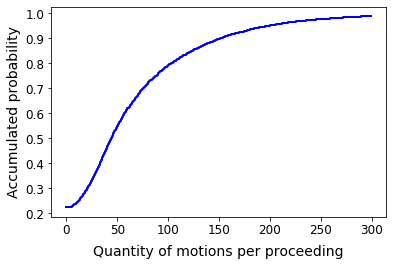

In [12]:
plt.step(dist1[:,0],dist1[:,1],color='blue', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accumulated probability', size=14)
plt.xlabel('Quantity of motions per proceeding', fontsize=14, labelpad=8)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/dist_mov.png", facecolor='white', dpi=100)
plt.show()

Let's evaluate the distribution of tokens quantities per motion.

In [13]:
%%time

leng=[]
for i in range(len(mov)):
    for j in range(len(mov[i])):
        leng.append(np.shape(tokens2matrix(tokenizer(mov[i][j][1])))[0])

CPU times: user 9min 6s, sys: 6.71 s, total: 9min 12s
Wall time: 9min 12s


In [14]:
%%time

dist=[]
leng=np.array(leng)

for i in range(100):
    dist.append([i,np.mean(leng<=i)])
    
dist=np.array(dist)

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 195 ms


In [15]:
dist

array([[0.00000000e+00, 1.60344548e-06],
       [1.00000000e+00, 8.06901871e-02],
       [2.00000000e+00, 1.32794148e-01],
       [3.00000000e+00, 2.20510633e-01],
       [4.00000000e+00, 2.91059028e-01],
       [5.00000000e+00, 3.41333457e-01],
       [6.00000000e+00, 4.06920791e-01],
       [7.00000000e+00, 4.40290095e-01],
       [8.00000000e+00, 4.75325379e-01],
       [9.00000000e+00, 5.22958934e-01],
       [1.00000000e+01, 5.46022894e-01],
       [1.10000000e+01, 5.74238724e-01],
       [1.20000000e+01, 5.93731811e-01],
       [1.30000000e+01, 6.16701167e-01],
       [1.40000000e+01, 7.17009510e-01],
       [1.50000000e+01, 7.37075027e-01],
       [1.60000000e+01, 7.51355312e-01],
       [1.70000000e+01, 7.58894713e-01],
       [1.80000000e+01, 7.65412719e-01],
       [1.90000000e+01, 7.73118878e-01],
       [2.00000000e+01, 7.83852342e-01],
       [2.10000000e+01, 8.00140141e-01],
       [2.20000000e+01, 8.14580771e-01],
       [2.30000000e+01, 8.24074772e-01],
       [2.400000

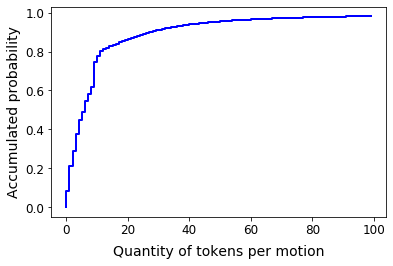

In [15]:
plt.step(dist[:,0],dist[:,1],color='blue', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accumulated probability', fontsize=14)
plt.xlabel('Quantity of tokens per motion', fontsize=14, labelpad=8)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/dist_token.png", facecolor='white', dpi=100)
plt.show()

Approx. $95\%$ of motions have less than 70 tokens.

### Getting the data and saving it

In [16]:
%%time

len1=5 #vamos pegar somente as últimas len1 movimentações
len2=70 #vamos pegar somente os primeiros len2 tokens de cada movimentação

X,y=get_X_y_w2v(mov,tags,len1,len2)

Number of valid proceedings (with motions and tags): 6449 

20.0 % concluded
40.0 % concluded
60.0 % concluded
80.0 % concluded
100.0 % concluded
CPU times: user 24.5 s, sys: 228 ms, total: 24.8 s
Wall time: 24.8 s


In [17]:
X.shape

(6449, 5, 70, 100)

Saving data

In [18]:
np.save('data/X_w2v.npy', X)
np.save('data/y_w2v.npy', y)